In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## MS-COCO 데이터세트 다운로드 및 준비

[MS-COCO 데이터세트](http://cocodataset.org/#home)를 사용하여 모델을 훈련합니다. 데이터세트에는 82,000개가 넘는 이미지가 포함되어 있으며, 각 이미지에는 최소 5개의 다른 캡션 주석이 있습니다. 아래 코드는 자동으로 데이터세트를 다운로드하고 추출합니다.

**주의: 대용량 다운로드가 진행**됩니다. 13GB 파일의 훈련 세트를 사용합니다.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 226s 0us/step


## 선택 사항: 훈련 세트의 크기를 제한합니다.

이 튜토리얼의 학습 속도를 높이기 위해 30,000개의 캡션과 해당 이미지를 사용하여 모델을 훈련합니다. 더 많은 데이터를 사용하도록 선택하면 캡션 품질이 향상됩니다.

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# 한개 이미지당 5개 캡션이 존재하므로 이를 묶어주는 작업
image_path_to_caption = collections.defaultdict(list)  # key값이 없을 경우 미리 지정해 놓은 초기(default)값을 반환하는 dictionary 구조
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"  # soc와 eoc를 붙여줘서 캡션의 시작과 끝을 표기해줌
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])  # 이미지의 위치를 만들어 주는 코드
  image_path_to_caption[image_path].append(caption)

In [6]:
image_paths = list(image_path_to_caption.keys())  # 위에서 만든 딕셔너리 구조에서 이미지의 id인 key값을 가져옴
random.shuffle(image_paths)  # 이 key 배열을 무작위로 섞으

train_image_paths = image_paths[:6000]  # 섞은 리스트에서 6000개만 추출(위 코드와 합쳐지면 6000개를 랜덤으로 뽑은 꼴이 됨)
print(len(train_image_paths))

6000


In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]  # 훈련에서 사용할 이미지에 대한 캡션만 뽑는 코드
  train_captions.extend(caption_list)  # extend(iterable)는 리스트 끝에 가장 바깥쪽 iterable의 모든 항목을 추가(즉, iterable의 모든 원소를 개별로 추가)
  img_name_vector.extend([image_path] * len(caption_list)) # 한개 이미지당 캡션이 여러개이므로 숫자를 맞춰주기 위해 이미지 백터에 해당하는 캡션 숫자만큼 넣어줌(이래야 캡션이랑 이미지랑 수가 맞음)

In [8]:
print(train_captions[0])
print(img_name_vector[0])

<start> A person on some skis in the snow. <end>
/content/train2014/COCO_train2014_000000419724.jpg


## InceptionV3를 사용하여 이미지 전처리하기

다음으로, (Imagenet에 대해 사전 훈련된) InceptionV3을 사용하여 각 이미지를 분류합니다. 마지막 컨볼루셔널 레이어에서 특성을 추출합니다.

먼저 다음을 수행하여 이미지를 InceptionV3의 예상 형식으로 변환합니다.

- 이미지를 299px x 299px로 크기 조정합니다.
- [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) 메서드로 [이미지를 사전 처리](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage)하여 -1에서 1 범위의 픽셀을 포함하도록 이미지를 정규화합니다. 이는 InceptionV3를 훈련하는 데 사용되는 이미지의 형식과 일치합니다.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # JPEG로 인코딩 된 이미지를 uint8 텐서로 디코딩하는 코드. channel=3이면 rgb로 디코딩 함을 의미
    img = tf.image.resize(img, (299, 299))  # 이미지 사이즈 재조정
    img = tf.keras.applications.inception_v3.preprocess_input(img)  # 인셉션 V3가 인식하는 텐서 포맷으로 변환
    return img, image_path

## InceptionV3 초기화 및 사전 훈련된 Imagenet 가중치 로드하기

이제 출력 레이어가 InceptionV3 아키텍처의 마지막 컨볼루셔널 레이어인 tf.keras 모델을 만듭니다. 이 레이어의 출력 형상은 `8x8x2048`입니다. 이 예제에서는 attention을 사용하므로 마지막 컨볼루셔널 레이어를 사용합니다. 병목 현상이 발생할 수 있으므로 훈련 중에는 이 초기화를 수행하지 마세요.

- 네트워크를 통해 각 이미지를 전달하고 결과 벡터를 사전 (image_name --&gt; feature_vector)에 저장합니다.
- 모든 이미지가 네트워크를 통해 전달된 후, 사전을 디스크에 저장합니다.


In [10]:
# 참고 : https://runebook.dev/ko/docs/tensorflow/keras/applications/inceptionv3

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')   # Inception v3 아키텍처를 변수화. weights를 imagenet으로 할당하면 ImageNet에서 사전 학습한 가중치 할당
new_input = image_model.input    # InceptionV3 아키텍처의 input 레이어를 가져옴
hidden_layer = image_model.layers[-1].output     # InceptionV3 아키텍처의 마지막 컨볼루셔널 레이어를 가져옴

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)    # 위에서 정의한 input layer와 output layer를 이용해 모델 구축

87924736/87910968 [==============================] - 0s 0us/step


## InceptionV3에서 추출된 특성 캐시하기

InceptionV3로 각 이미지를 사전 처리하고 출력을 디스크에 캐시합니다. RAM에 출력을 캐시하는 것이 더 빠르지만, 메모리를 많이 사용하므로 이미지당 8 * 8 * 2048 부동 소수점이 필요합니다. 본 튜토리얼을 작성할 시점에서 Colab의 메모리 제한(현재 12GB의 메모리)을 초과합니다.

보다 정교한 캐싱 전략(예를 들어, 임의 액세스 디스크 I/O를 줄이기 위해 이미지를 분할)으로 성능을 향상할 수 있지만, 더 많은 코드가 필요합니다.

캐싱은 GPU로 Colab에서 실행하는 데 약 10분이 걸립니다. 진행률 표시줄을 보려면 다음을 수행합니다.

1. [tqdm](https://github.com/tqdm/tqdm)을 설치합니다.

    `!pip install tqdm`

2. tqdm를 가져옵니다.

    `from tqdm import tqdm`

3. 다음 줄을

    `for img, path in image_dataset:`

    다음으로 변경합니다.

    `for img, path in tqdm(image_dataset):`


#### [참고] TensorFlow Dataset 클래스란? (참고 사이트 : https://www.youtube.com/watch?v=NUMzrqxQ4zk)
- batch를 구성
- 전처리 함수 맵핑
- shuffle 기능 구현
- window 데이터셋 구성
- prefetch 옵션 등 제공
=> 데이터 파이프라인을 구성할 때 매우 유용한 클래스
즉, Dataset 클래스를 이용해 데이터 전처리 및 모델로의 공급이 원활하고 깔끔해짐

##### Dataset 클래스의 주요 메소드
1. tf.data.Dataset.from_tensor_slices(array) => numpy array를 Dataset 클래스로 변환
2. window(size=int, stride=int, drop_remainder=bool) => 이 size를 이용해 전체 데이터를 size에 맞는 분할로 쪼갤 수 있음. stride는 다음 window로 넘어갈 때 건너뛰는 사이즈. drop_remainder는 window보다 작은 사이즈만이 남았을 때 이 값들을 window로 묶지 않는 코드(True로 줘야 작동)
3. shuffle(buffer_size) => 0 to buffer_size-1 까지의 인덱스 사이에서 랜덤 추출
이후 추출된 데이터셋을 제외한 후 buffer_size to 2*buffer_size-1
4. map => 함수를 맵핑. ptyhon의 map과 유사(특정 리스트에 함수를 적용시켜주는 코드)
5. flat_map => 함수를 맵핑한 뒤 결과를 flat하게 만들어 줌(return 값이 무조건 Dataset object여야 함)
6. prefetch => 미리 데이터를 fetch 하는 갯수 의미(병렬처리를 하므로 학습속도를 개선)
7. zip => python의 zip과 동일(두 리스트의 같은 인덱스에 있는 애들끼리 묶어줌)
8. batch => batch해주는 코드(batch의 개수를 입력해줘야 함. window의 인자와 비슷하게 batch_size와 drop_remainder가 존재)

In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))    # 이미지 벡터 중 고유값만 가져옴 => 중복값 제거

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)  # 메모리의 데이터에서 Dataset을 구성하는 코드(무작위로 선택한 이미지를 학습을 위한 batch로 병합)
image_dataset = image_dataset.map(                                # load_image 함수를 맵핑하는 코드. batch size=16로 설정
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)    

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3])) 
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")  # .numpy() 는 텐서를 numpy 배열로 변경
    np.save(path_of_feature, bf.numpy())

## 캡션 전처리 및 토큰화하기

- 먼저 캡션을 토큰화합니다(예: 공백으로 분할). 이를 통해 데이터의 모든 고유 단어(예: "서핑", "축구" 등)에 대한 어휘를 제공합니다.
- 다음으로, 단어 크기를 상위 5,000개 단어로 제한하여 메모리를 절약합니다. 다른 모든 단어는 토큰 "UNK"(알 수 없음)로 대체됩니다.
- 그런 다음, 단어 대 인덱스 및 인덱스 대 단어 매핑을 만듭니다.
- 마지막으로, 모든 시퀀스를 가장 긴 시퀀스와 같은 길이로 채웁니다.

In [12]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## 데이터를 훈련 및 테스트로 분할하기

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)   # 이미지와 캡션을 연결하는 딕셔너리 생성

# Create training and validation sets using an 80-20 split randomly. 
img_keys = list(img_to_cap_vector.keys())  # 딕셔너리 키만 추출
random.shuffle(img_keys)  # 위의 딕셔너리 키를 랜덤으로 섞어줌

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]   # 80%를 훈련 데이터로 20%를 테스트 데이터로 분할

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6004, 6004)

## 훈련을 위한 tf.data 데이터세트 생성하기


이미지와 캡션이 준비되었습니다! 다음으로 모델 훈련에 사용할 `tf.data` 데이터세트를 만들어 봅시다.

In [20]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 모델

재미있는 사실: 아래의 디코더는 [Attention을 사용한 신경망 기계 번역](https://www.tensorflow.org/text/tutorials/nmt_with_attention)의 디코더와 동일합니다.

모델 아키텍처는 [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) 논문에서 영감을 얻었습니다.

- 이 예제에서는 InceptionV3의 하위 컨볼루셔널 레이어에서 특성을 추출하여 형상 (8, 8, 2048)의 백터를 제공합니다.
- (64, 2048)의 형상으로 스쿼시합니다.
- 그런 다음, 이 벡터는 CNN Encoder(단일 완전 연결 레이어로 구성)를 통해 전달됩니다.
- RNN(여기서는 GRU)이 다음 단어를 예측하기 위해 이미지를 살펴봅니다.

In [23]:
# 가장 기본적인 Attention 메커니즘인 Bahdanau Attention 구현 => https://hcnoh.github.io/2018-12-11-bahdanau-attention 링크 참고

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()   # super 명령어는 상속 관계에서 상속의 대상인 부모 클래스를 호출하는 함수
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [25]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 체크포인트

In [28]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [29]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## 훈련하기

- 각 `.npy` 파일에 저장된 특성을 추출한 다음, 해당 특성을 endcoder를 통해 전달합니다.
- encoder 출력, hidden state(0으로 초기화됨) 및 decoder 입력(start token)이 decoder로 전달됩니다.
- decoder는 예측값 및 decoder hidden state를 반환합니다.
- 그런 다음 decoder hidden state가 모델로 다시 전달되고 예측값은 손실을 계산하는 데 사용됩니다.
- teacher forcing를 사용하여 decoder에 대한 다음 입력을 결정합니다.
- teacher forcing은 대상 단어가 다음 입력으로 decoder에 전달되는 기법입니다.
- 마지막 스텝은 그래디언트를 계산하고 이를 옵티마이저에 적용하여 역전파하는 것입니다.


In [30]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [31]:
@tf.function  # 데코레이터 사용
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)  # 여기에서 이미지를 인코딩함

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)   # 여기에서 디코딩함

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.8556
Epoch 1 Batch 100 Loss 1.0463
Epoch 1 Batch 200 Loss 0.9121
Epoch 1 Batch 300 Loss 0.8103
Epoch 1 Loss 0.979250
Time taken for 1 epoch 173.56 sec

Epoch 2 Batch 0 Loss 0.7926
Epoch 2 Batch 100 Loss 0.6862
Epoch 2 Batch 200 Loss 0.7347
Epoch 2 Batch 300 Loss 0.7052
Epoch 2 Loss 0.740108
Time taken for 1 epoch 72.19 sec

Epoch 3 Batch 0 Loss 0.7301
Epoch 3 Batch 100 Loss 0.6364
Epoch 3 Batch 200 Loss 0.6851
Epoch 3 Batch 300 Loss 0.6697
Epoch 3 Loss 0.663289
Time taken for 1 epoch 69.61 sec

Epoch 4 Batch 0 Loss 0.6511
Epoch 4 Batch 100 Loss 0.6157
Epoch 4 Batch 200 Loss 0.6524
Epoch 4 Batch 300 Loss 0.6079
Epoch 4 Loss 0.613417
Time taken for 1 epoch 70.36 sec

Epoch 5 Batch 0 Loss 0.6600
Epoch 5 Batch 100 Loss 0.6186
Epoch 5 Batch 200 Loss 0.5609
Epoch 5 Batch 300 Loss 0.5282
Epoch 5 Loss 0.576644
Time taken for 1 epoch 70.77 sec

Epoch 6 Batch 0 Loss 0.5524
Epoch 6 Batch 100 Loss 0.4921
Epoch 6 Batch 200 Loss 0.5372
Epoch 6 Batch 300 Loss 0.5527
Epoch 6 Los

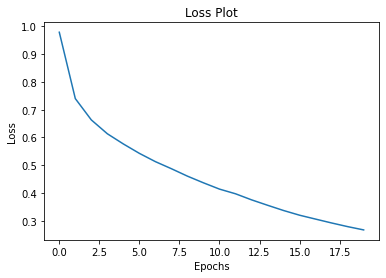

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## 캡션!

- evaluate 함수는 여기에서 teacher forcing을 사용하지 않는다는 점을 제외하고 훈련 루프와 유사합니다. 각 타임스텝에서 decoder로의 입력은 hidden state 및 encoder 출력과 함께 이전 예측값입니다.
- 모델이 end 토큰을 예측할 때 예측을 중지합니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [34]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [35]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a person is posing on a snow hill with skis <end>
Prediction Caption: a man on skis behind a ski <end>


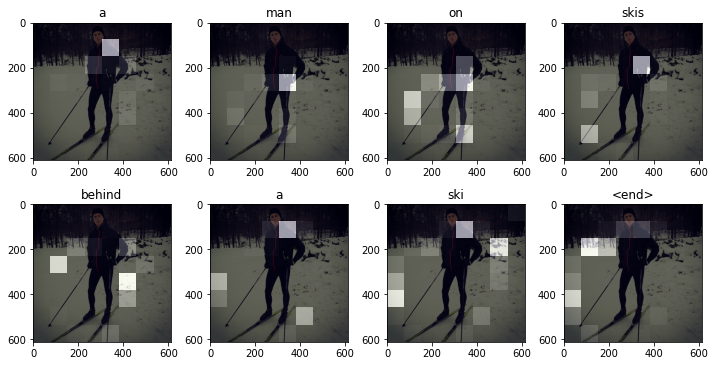

In [36]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## 자체 이미지로 시도해보기

재미를 위해 방금 훈련한 모델로 자체 이미지를 캡션하는 데 사용할 수 있는 방법을 제공했습니다. 상대적으로 적은 양의 데이터로 훈련되었으므로 이미지가 훈련 데이터와 다를 수 있습니다(결과가 이상할 수 있습니다!).


Prediction Caption: a tree filled with large blossoming tree background <end>


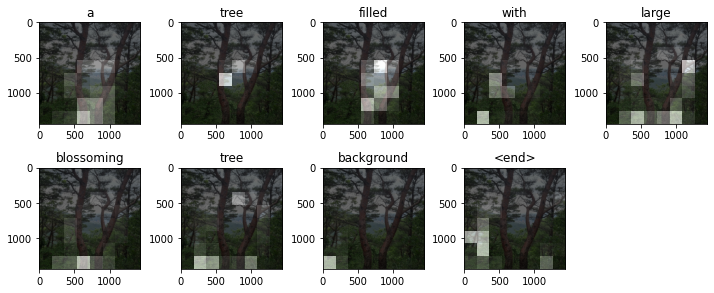

In [42]:
image_path = '/content/drive/MyDrive/5조/코드/291019717_1724510077882049_407902125882126680_n.jpg'

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image